### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import tensorflow as tf
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
import dask.dataframe as dd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

2023-05-21 17:05:28.483081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_6517/1643725646.py:9: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


### Params

In [2]:
write_to_file = False
read_from_file = True

In [12]:
sns.set(style="whitegrid", font='Times New Roman', font_scale=1.2)

color = '#1982C4'
color2 = '#FF595E'
color3 = '#8AC926'
color4 = "#FFCA3A"
color5 = "#6A4C93"

### Loading data

In [4]:
if read_from_file == False:    
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    sys.path.append(path)

    # Read dataframes using Dask
    df1 = dd.read_csv(path + '/data/predictions/BS_rolling_v2.csv')
    df2 = dd.read_csv(path + '/data/predictions/BS_GARCH_v2.csv')
    df3 = dd.read_csv(path + '/data/predictions/BS_IV_surface2.csv')
    df4 = dd.read_csv(path + '/data/predictions/heston.csv')
    df5 = dd.read_csv(path + '/data/predictions/11.05 1 mnd test sett full model run.csv')

    # Rename columns
    df1 = df1.rename(columns={"BS": "Rolling"})
    df2 = df2.rename(columns={"BS": "GARCH"})
    df3 = df3.rename(columns={"BS": "IV"})
    df4 = df4.rename(columns={"Heston_price": "Heston"})
    df5 = df5.rename(columns={"Prediction": "LSTM-MLP"})

    # Define the columns to merge on
    on_columns = ["Quote_date", "TTM", "Price", "Strike"]

    # Merge dataframes
    df = df1.merge(df2, on=on_columns, suffixes=('', '_df2')).merge(df3, on=on_columns, suffixes=('', '_df3')).merge(df4, on=on_columns, suffixes=('', '_df4')).merge(df5, on=on_columns, suffixes=('', '_df5'))

    # Convert back to Pandas DataFrame (if needed)
    df = df.compute()

    print(len(df))


In [38]:
df = df[['Quote_date', 'Price', 'Underlying_last', 'Strike', 'TTM', 'Rolling', 'GARCH', 'IV', 'Heston', 'LSTM-MLP', 'R']]

In [5]:
if write_to_file:
    df.to_csv(path + '/data/predictions/combined_predictions_BS_v2.csv', index=False)

In [6]:
if read_from_file:
    path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    sys.path.append(path)
    df = pd.read_csv(path + '/data/predictions/combined_predictions_BS_v2.csv')

In [7]:
# Print RMSE for all the dataframes
print("RMSE for Rolling: ", np.sqrt(mean_squared_error(df["Price"], df["Rolling"])))
print("RMSE for GARCH: ", np.sqrt(mean_squared_error(df["Price"], df["GARCH"])))
print("RMSE for IV: ", np.sqrt(mean_squared_error(df["Price"], df["IV"])))
print("RMSE for Heston: ", np.sqrt(mean_squared_error(df["Price"], df["Heston"])))
print("RMSE for LSTM-MLP: ", np.sqrt(mean_squared_error(df["Price"], df["LSTM-MLP"])))


RMSE for Rolling:  35.34827998954488
RMSE for GARCH:  38.09814429210051
RMSE for IV:  19.96131011470614
RMSE for Heston:  13.288475600526862
RMSE for LSTM-MLP:  14.248024826715412


# Graphs

Text(0.5, 1.0, 'RMSE for LSTM-MLP by Month')

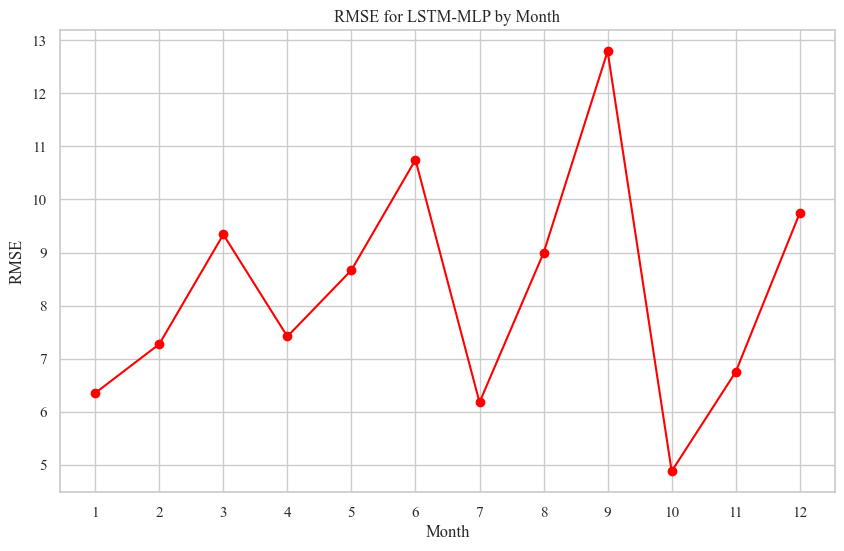

In [8]:
# Plot the RMSE for every month
df = df.copy()

df["Quote_date"] = pd.to_datetime(df["Quote_date"])
df["Month"] = df["Quote_date"].dt.month
df["LSTM-MLP_RMSE"] = np.sqrt((df["Price"] - df["LSTM-MLP"])**2)

df_by_month = df.groupby("Month").mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_by_month["Month"], df_by_month["LSTM-MLP_RMSE"], marker="o", color="red")
plt.xticks(np.arange(1, 13, 1))
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.title("RMSE for LSTM-MLP by Month")

## RMSE over time

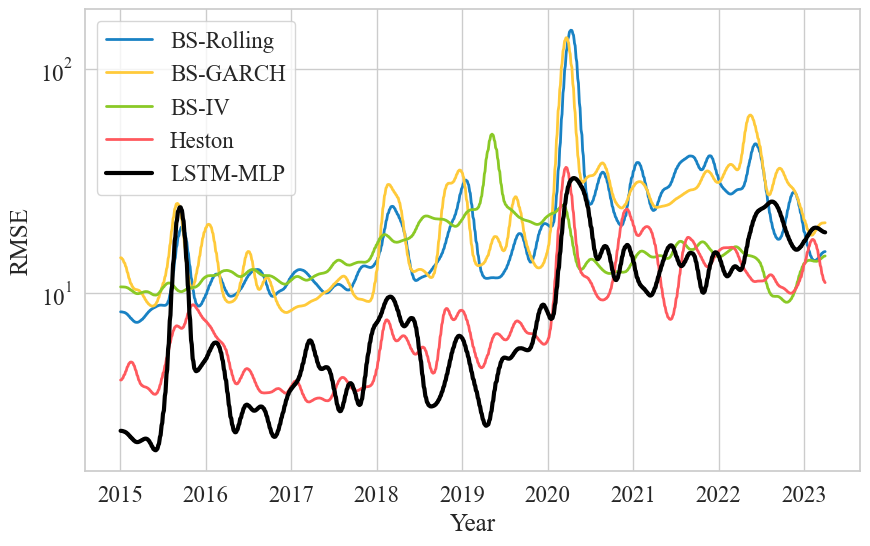

In [13]:
# Define a function to calculate RMSE
def calculate_rmse(group):
    rmse_model_1 = np.sqrt(mean_squared_error(group["Price"], group["Rolling"]))
    rmse_model_2 = np.sqrt(mean_squared_error(group["Price"], group["GARCH"]))
    rmse_model_3 = np.sqrt(mean_squared_error(group["Price"], group["IV"]))
    rmse_model_4 = np.sqrt(mean_squared_error(group["Price"], group["Heston"]))
    rmse_model_5 = np.sqrt(mean_squared_error(group["Price"], group["LSTM-MLP"]))
    return pd.Series({"RMSE_Model_1": rmse_model_1, "RMSE_Model_2": rmse_model_2, "RMSE_Model_3": rmse_model_3, "RMSE_Model_4": rmse_model_4, "RMSE_Model_5": rmse_model_5})

# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("Quote_date").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 15
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_1", label="BS-Rolling", ax=ax, color = color, linewidth=2)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_2", label="BS-GARCH", ax=ax, color = color4, linewidth=2)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_3", label="BS-IV", ax=ax, color = color3, linewidth=2)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_4", label="Heston", ax=ax, color = color2, linewidth=2)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_5", label="LSTM-MLP", ax=ax, color="black", linewidth=3)


# Set the interval for x-axis labels
#ax.xaxis.set_major_locator(ticker.MultipleLocator(base=150))


plt.xlabel("Year")
plt.ylabel("RMSE")
plt.yscale("log")
plt.legend()
plt.show()

# Diviation

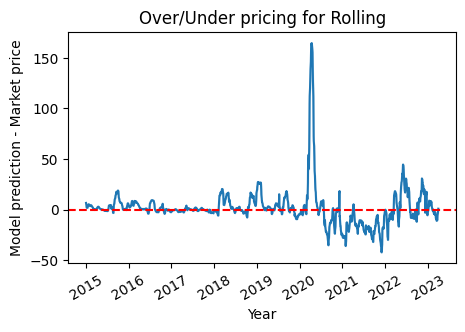

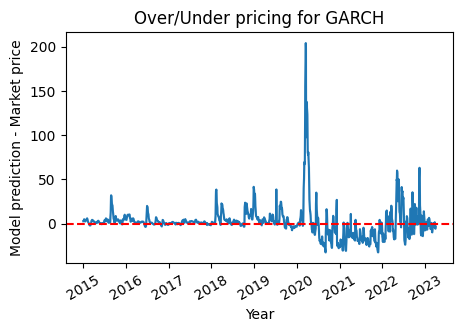

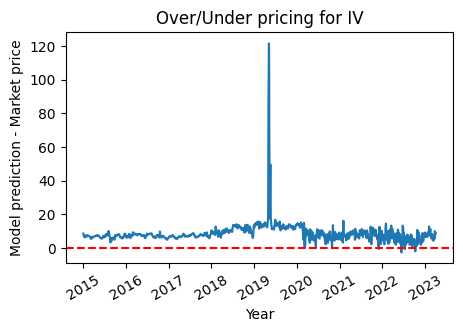

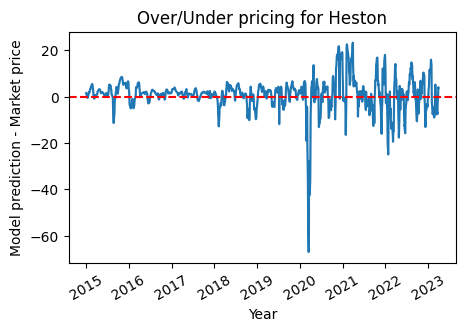

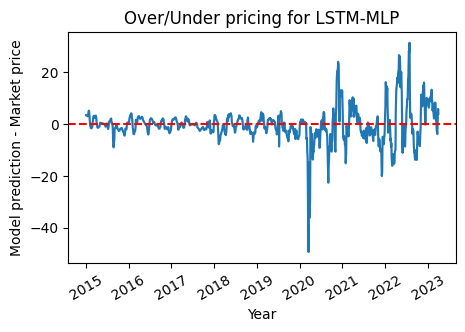

In [42]:
for model in ["Rolling", "GARCH", "IV", "Heston", "LSTM-MLP"]:
    # New column with the difference between the prediction and the actual value
    df_temp = df.copy()
    df_temp["Diff"] = df[model] - df["Price"]

    fig, ax = plt.subplots(figsize=(5, 3))

    # Smooth the difference by using gaussian filter
    sigma = 15
    df_temp["Diff"] = gaussian_filter1d(df_temp["Diff"], sigma=sigma)

    # Plot the difference
    sns.lineplot(data=df_temp, x="Quote_date", y="Diff", ax=ax)

    # Set the interval for x-axis labels
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(base=365))
    plt.ylabel("Price - Model 3 Prediction")

    # Add zero line
    plt.axhline(y=0, color="red", linestyle="--", label="Actual Price")

    plt.xlabel("Year")
    plt.ylabel("Model prediction - Market price")
    plt.title("Over/Under pricing for " + model)
    plt.xticks(rotation=30)
    plt.show()


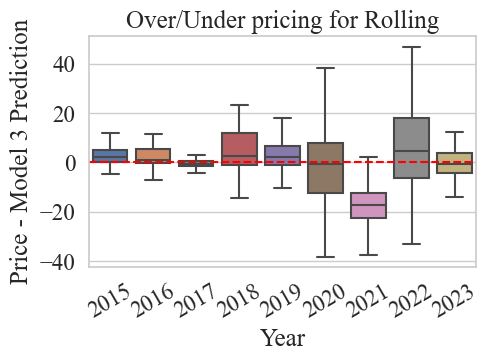

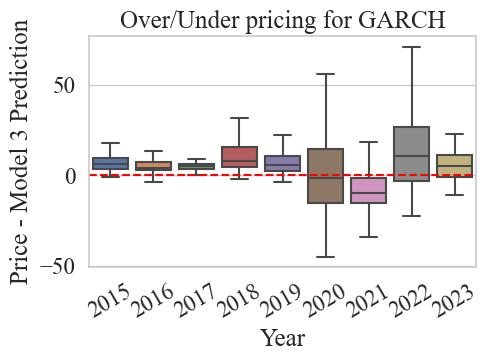

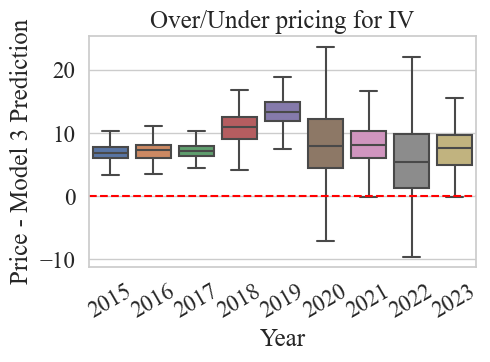

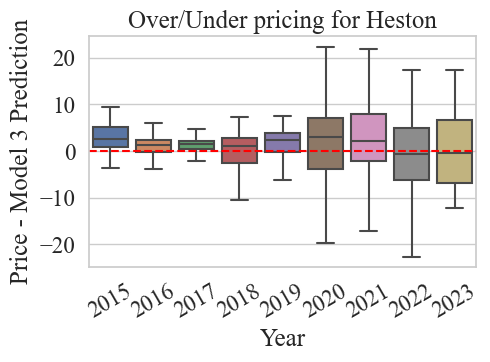

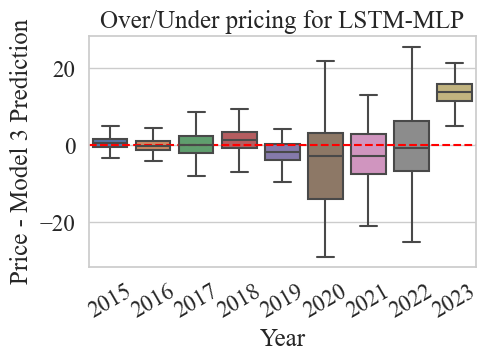

In [16]:
# Same as above, but using boxplots
for model in ["Rolling", "GARCH", "IV", "Heston", "LSTM-MLP"]:
    df_temp = df.copy()
    df_temp["Diff"] = df[model] - df["Price"]
    df_temp["Quote_date"] = pd.to_datetime(df_temp["Quote_date"])
    df_temp["Year"] = df_temp["Quote_date"].dt.year
    df_temp["Month"] = df_temp["Quote_date"].dt.month
    df_temp["Day"] = df_temp["Quote_date"].dt.day

    df_temp = df_temp.groupby(["Year", "Month", "Day"]).mean().reset_index()

    fig, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(data=df_temp, x="Year", y="Diff", ax=ax, showfliers=False)
    plt.axhline(y=0, color="red", linestyle="--", label="Actual Price")
    plt.ylabel("Price - Model 3 Prediction")
    plt.xlabel("Year")
    plt.title("Over/Under pricing for " + model)
    plt.xticks(rotation=30)
    plt.show()

### TTM

In [18]:
df["TTM"] = df["TTM"] * 365

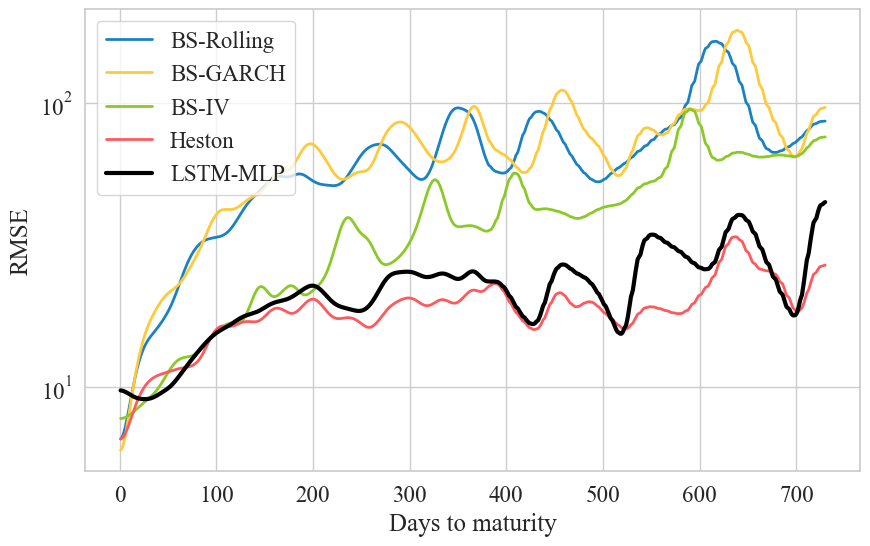

In [22]:
# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("TTM").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 8
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_1", label="BS-Rolling", ax=ax, color = color, linewidth=2)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_2", label="BS-GARCH", ax=ax, color = color4, linewidth=2)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_3", label="BS-IV", ax=ax, color = color3, linewidth=2)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_4", label="Heston", ax=ax, color = color2, linewidth=2)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_5", label="LSTM-MLP", ax=ax, color="black", linewidth=3)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100))


plt.xlabel("Days to maturity")
plt.ylabel("RMSE")
plt.yscale("log")
plt.legend()
plt.show()

### Moneyness

In [23]:
# Add moneyness
df["Moneyness"] = df["Underlying_last"] / df["Strike"]
df["Moneyness"] = df["Moneyness"].round(2)

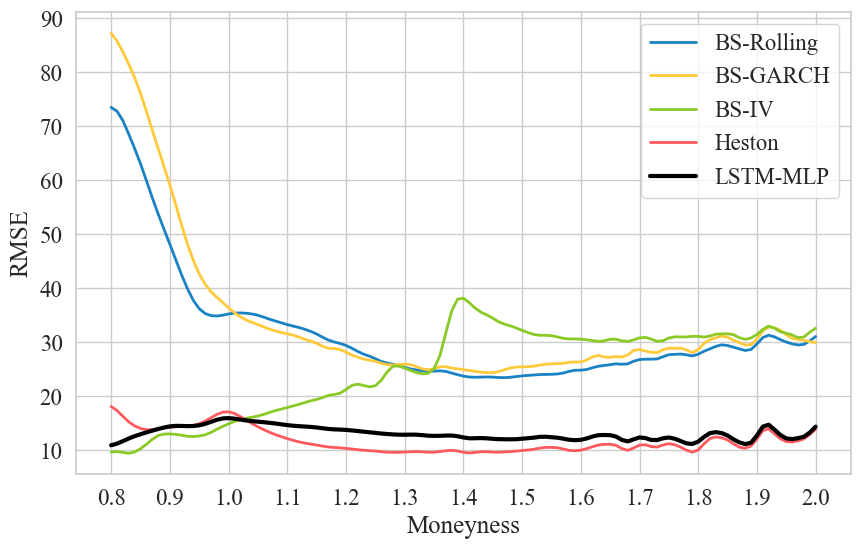

In [30]:
# Group data by Moneyness and calculate RMSE for each group
rmse_df = df.groupby("Moneyness").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 1.3
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_1", label="BS-Rolling", ax=ax, color = color, linewidth=2)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_2", label="BS-GARCH", ax=ax, color = color4, linewidth=2)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_3", label="BS-IV", ax=ax, color = color3, linewidth=2)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_4", label="Heston", ax=ax, color = color2, linewidth=2)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_5", label="LSTM-MLP", ax=ax, color="black", linewidth=3)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))

plt.xlabel("Moneyness")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Tabel

Split by TTM and moneyness

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Assuming df is a DataFrame with the required columns

df_low_money = df[df["Underlying_last"] / df["Strike"] < 0.97]
df_low_money.name = "<0.97"
df_mid_money = df[(df["Underlying_last"] / df["Strike"]).between(0.95, 1.05, inclusive=True)]
df_mid_money.name = "0.95-1.05"
df_high_money = df[df["Underlying_last"] / df["Strike"] > 1.03]
df_high_money.name = ">1.03"

df_table = pd.DataFrame(columns=['Moneyness', 'Maturity', 'Rolling', 'GARCH', 'IV', "Heston", "LSTM-MLP"])
maturity_intervals = [(0,30), (30, 90), (90, 300), (300, 730)]

for dataframe in [df_low_money, df_mid_money, df_high_money]:
    for start, end in maturity_intervals:
        df_temp = dataframe[(dataframe["TTM"]).between(start, end, inclusive=True)]
        model_1 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Rolling"]))
        model_2 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["GARCH"]))
        model_3 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["IV"]))
        model_4 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Heston"]))
        model_5 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["LSTM-MLP"]))
        df_table.loc[len(df_table.index)] = [dataframe.name, f"{start}-{end}", model_1, model_2, model_3, model_4, model_5]


# Only provide the first moneyness column, not for the other maturities for that moneyness level
df_table["Moneyness"] = df_table["Moneyness"].where(df_table["Maturity"] == "0-10", "")


# Round the RMSE values to 2 decimal places
df_table = df_table.round(2)


# Write to file
df_table.to_csv('RMSE_benchmark_tabel.csv', encoding='utf-8', index=False)

# Write to latex
with open('RMSE_benchmark_tabel.tex', 'w') as tf:
     tf.write(df_table.to_latex())


Split by year

In [48]:
# Make a table with the RMSE values for each model for each year
df_table = pd.DataFrame(columns=['Year', 'Rolling', 'GARCH', 'IV', "Heston", "LSTM-MLP"])

for year in range(2015, 2024):
    df["Quote_date"] = pd.to_datetime(df["Quote_date"], format="%Y-%m-%d")
    df_temp = df[df["Quote_date"].dt.year == year]
    model_1 = np.sqrt(mean_squared_error(df_temp["Price"], df_temp["Rolling"]))
    model_2 = np.sqrt(mean_squared_error(df_temp["Price"], df_temp["GARCH"]))
    model_3 = np.sqrt(mean_squared_error(df_temp["Price"], df_temp["IV"]))
    model_4 = np.sqrt(mean_squared_error(df_temp["Price"], df_temp["Heston"]))
    model_5 = np.sqrt(mean_squared_error(df_temp["Price"], df_temp["LSTM-MLP"]))
    df_table.loc[len(df_table.index)] = [year, model_1, model_2, model_3, model_4, model_5]

# Have the last row be the average of all the options
rolling = np.sqrt(mean_squared_error(df["Price"], df["Rolling"]))
garch = np.sqrt(mean_squared_error(df["Price"], df["GARCH"]))
iv = np.sqrt(mean_squared_error(df["Price"], df["IV"]))
heston = np.sqrt(mean_squared_error(df["Price"], df["Heston"]))
main = np.sqrt(mean_squared_error(df["Price"], df["LSTM-MLP"]))
df_table.loc[len(df_table.index)] = ["Average", rolling, garch, iv, heston, main]

# Round the RMSE values to 2 decimal places
df_table = df_table.round(2)

# Write to file
df_table.to_csv('RMSE_benchmark_tabel_year.csv', encoding='utf-8', index=False)

# Write to latex
with open('RMSE_benchmark_tabel_year.tex', 'w') as tf:
    tf.write(df_table.to_latex())